In [1]:
from astropy.coordinates.angle_utilities import angular_separation
from astropy.coordinates import SkyCoord, get_sun,FK4,get_body, EarthLocation
from astropy.time import Time

from datetime import timedelta
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

import os
import glob
import numpy as np
import astropy.units as u
from scipy.interpolate import splrep,BSpline

from tqdm.notebook import tqdm

import RAEAnglesUtilities as rae
import pickle
import glob

In [2]:
# Load the file to inspect its contents
filename = r"C:\Users\adamf\Documents\PhD\Diffraction\interpolatedRAE2MasterFile.csv"

rawData = pd.read_csv(filename)
data = rawData
data['time'] = pd.to_datetime(data['time'])
data.drop('Unnamed: 0',axis=1,inplace=True)
data.set_index('time',inplace=True)

In [3]:
start_date = pd.to_datetime("1974-01-01 14:00")
end_date = pd.to_datetime("1975-12-31 16:00")

# Selecting rows within the date range
earthOccult = data[(data.index >= start_date) & (data.index <= end_date)].copy()

In [8]:
planets = ['Mercury', 'Venus', 'Mars', 'Jupiter', 'Saturn', 'Uranus', 'Neptune']


In [15]:
sources = {
    "CAS-A": SkyCoord(ra="23h23m26s", dec="+58d48m00s", frame="fk4", equinox="B1950", unit=(u.hourangle, u.deg)),
    "Cygnus-A": SkyCoord(ra="19h59m28s", dec="+40d44m02s", frame="fk4", equinox="B1950", unit=(u.hourangle, u.deg)),
    "Sag-A": SkyCoord(ra="17h45m40s", dec="-29d00m28s", frame="fk4", equinox="B1950", unit=(u.hourangle, u.deg)),
    "Fornax-A": SkyCoord(ra="03h22m41s", dec="-37d12m30s", frame="fk4", equinox="B1950", unit=(u.hourangle, u.deg)),
}

In [9]:
os.makedirs('occultationResults', exist_ok=True)

In [13]:
for planet in planets:
    earthOccult[f'{planet}Angle'] = rae.solarSystemAngles(earthOccult, planet)
    earthOccult[f'{planet}Vis'] = rae.isVisible(earthOccult, earthOccult[f'{planet}Angle'])
    
    stats = rae.occultationStatisticsSigma(earthOccult, f'{planet}Vis', n=5)

    # Save stats as a pickle file
    filename = f"occultationResults/{planet}medians.pkl"
    with open(filename, 'wb') as f:  # 'wb' for writing binary
        pickle.dump(stats, f)

C:\Users\adamf\Documents\PhD\Diffraction\RAEAnglesUtilities.py:160: RuntimeWarning: divide by zero encountered in true_divide
  moonWidth = np.degrees(np.tan(moonRad/moonDist))
C:\Users\adamf\Documents\PhD\Diffraction\RAEAnglesUtilities.py:160: RuntimeWarning: invalid value encountered in tan
  moonWidth = np.degrees(np.tan(moonRad/moonDist))


  0%|          | 0/9 [00:00<?, ?it/s]

Skipping empty occultation period: 1974-05-08 00:39:58.018000 to 1974-05-08 02:13:54.883000
Skipping empty occultation period: 1974-07-10 00:00:00.163000 to 1974-07-10 00:05:13.090000


C:\Users\adamf\AppData\Roaming\Python\Python38\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\adamf\AppData\Roaming\Python\Python38\site-packages\numpy\core\_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\Users\adamf\AppData\Roaming\Python\Python38\site-packages\numpy\core\_methods.py:264: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\Users\adamf\AppData\Roaming\Python\Python38\site-packages\numpy\core\_methods.py:222: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
C:\Users\adamf\AppData\Roaming\Python\Python38\site-packages\numpy\core\_methods.py:256: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


NaN detected in non-occulted period
0
1974-07-15 03:45:25.953000
1974-07-15 03:53:37.463000
Skipping empty occultation period: 1974-07-26 18:45:10.287000 to 1974-07-27 05:21:52.134000
NaN detected in non-occulted period
0
1974-08-08 00:00:29.446000
1974-08-08 00:07:39.522000
NaN detected in occultation period
2
1974-08-18 00:00:07.781000
1974-08-18 00:03:04.399000
Skipping empty occultation period: 1974-09-04 23:59:57.426000 to 1974-09-05 00:03:42.046000
NaN detected in non-occulted period
0
1974-09-05 23:51:53.419000
1974-09-05 23:59:59.193000
Skipping empty occultation period: 1974-09-23 00:00:03.926000 to 1974-09-23 00:04:30.781000
NaN detected in non-occulted period
0
1974-09-23 23:44:16.464000
1974-09-23 23:59:26.542000
Skipping empty occultation period: 1974-09-25 01:15:23.668000 to 1974-09-25 03:59:00.460000
Skipping empty occultation period: 1974-11-03 18:25:04.019000 to 1974-11-03 18:28:12.186000
Skipping empty occultation period: 1974-11-19 23:35:58.811000 to 1974-11-20 00:00

NaN detected in non-occulted period
0
1975-02-26 00:00:11.588000
1975-02-26 00:07:48.549000
Skipping empty occultation period: 1975-02-26 05:05:46.463000 to 1975-02-26 07:03:56.327000
Skipping empty occultation period: 1975-03-16 00:51:17.579000 to 1975-03-16 01:50:08.201000
NaN detected in non-occulted period
0
1975-03-30 23:54:44.320000
1975-03-30 23:59:55.348000
NaN detected in non-occulted period
0
1975-04-11 17:02:56.448000
1975-04-11 17:25:06.947000
Skipping empty occultation period: 1975-06-15 15:29:46.052000 to 1975-06-16 03:44:59.302000
Skipping empty occultation period: 1974-02-19 00:00:02.062000 to 1974-02-19 18:46:41.838000
Skipping empty occultation period: 1974-05-08 00:39:58.018000 to 1974-05-08 02:13:54.883000
Skipping empty occultation period: 1974-06-09 07:11:19.818000 to 1974-06-09 09:53:06.820000
Skipping empty occultation period: 1974-07-02 22:52:51.951000 to 1974-07-03 00:32:53.427000
Skipping empty occultation period: 1974-07-10 00:00:00.163000 to 1974-07-10 00:0

C:\Users\adamf\Documents\PhD\Diffraction\RAEAnglesUtilities.py:134: RuntimeWarning: invalid value encountered in true_divide
  dec = np.arcsin(z / r)
C:\Users\adamf\Documents\PhD\Diffraction\RAEAnglesUtilities.py:160: RuntimeWarning: divide by zero encountered in true_divide
  moonWidth = np.degrees(np.tan(moonRad/moonDist))
C:\Users\adamf\Documents\PhD\Diffraction\RAEAnglesUtilities.py:160: RuntimeWarning: invalid value encountered in tan
  moonWidth = np.degrees(np.tan(moonRad/moonDist))


  0%|          | 0/9 [00:00<?, ?it/s]

Skipping empty occultation period: 1974-05-23 21:05:56.772000 to 1974-05-24 00:00:18.592000
Skipping empty occultation period: 1974-06-08 17:58:09.586000 to 1974-06-08 18:51:31.955000
Skipping empty occultation period: 1974-06-17 00:10:40.047000 to 1974-06-17 00:24:54.435000
Skipping empty occultation period: 1974-06-20 14:55:06.477000 to 1974-06-21 00:00:06.299000
Skipping empty occultation period: 1974-07-10 00:00:00.163000 to 1974-07-10 00:05:13.090000
Skipping empty occultation period: 1974-07-10 23:49:02.300000 to 1974-07-10 23:58:19.098000


C:\Users\adamf\AppData\Roaming\Python\Python38\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\adamf\AppData\Roaming\Python\Python38\site-packages\numpy\core\_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\Users\adamf\AppData\Roaming\Python\Python38\site-packages\numpy\core\_methods.py:264: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\Users\adamf\AppData\Roaming\Python\Python38\site-packages\numpy\core\_methods.py:222: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
C:\Users\adamf\AppData\Roaming\Python\Python38\site-packages\numpy\core\_methods.py:256: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


NaN detected in non-occulted period
0
1974-09-22 00:00:09.661000
1974-09-22 00:02:58.621000
NaN detected in occultation period
1
1974-09-24 00:00:07.887000
1974-09-24 00:37:31.303000
NaN detected in occultation period
1
1974-10-13 00:00:03.777000
1974-10-13 00:48:01.930000
NaN detected in non-occulted period
0
1974-12-11 10:12:29.363000
1974-12-11 10:48:50.429000
NaN detected in non-occulted period
0
1975-01-18 16:37:24.664000
1975-01-18 17:23:58.139000
Skipping empty occultation period: 1975-03-22 23:59:58.785000 to 1975-03-23 00:56:11.973000
Skipping empty occultation period: 1975-04-18 02:49:04.632000 to 1975-04-18 04:25:32.980000
Skipping empty occultation period: 1974-05-23 21:05:56.772000 to 1974-05-24 00:00:18.592000
Skipping empty occultation period: 1974-05-27 21:25:38.689000 to 1974-05-28 00:13:03.519000
Skipping empty occultation period: 1974-06-17 00:10:40.047000 to 1974-06-17 00:24:54.435000
NaN detected in occultation period
2
1974-07-10 00:00:00.163000
1974-07-10 00:05:1

NaN detected in occultation period
1
1974-07-13 15:10:01.350000
1974-07-13 15:26:55.091000
Skipping empty occultation period: 1974-07-30 13:28:24.120000 to 1974-07-30 16:45:15.791000
NaN detected in non-occulted period
0
1974-09-22 00:00:09.661000
1974-09-22 00:02:58.621000
Skipping empty occultation period: 1974-09-24 00:00:07.887000 to 1974-09-24 00:37:31.303000
Skipping empty occultation period: 1974-11-16 00:07:32.360000 to 1974-11-16 01:06:09.701000
Skipping empty occultation period: 1974-11-20 15:07:18.697000 to 1974-11-20 15:58:36.343000
NaN detected in non-occulted period
0
1975-01-06 00:00:03.481000
1975-01-06 00:07:15.469000
NaN detected in non-occulted period
0
1975-01-18 16:37:24.664000
1975-01-18 17:23:58.139000
Skipping empty occultation period: 1975-04-18 02:49:04.632000 to 1975-04-18 04:25:32.980000
NaN detected in occultation period
1
1974-05-23 21:05:56.772000
1974-05-24 00:00:18.592000
Skipping empty occultation period: 1974-06-17 00:10:40.047000 to 1974-06-17 00:24:

C:\Users\adamf\Documents\PhD\Diffraction\RAEAnglesUtilities.py:134: RuntimeWarning: invalid value encountered in true_divide
  dec = np.arcsin(z / r)
C:\Users\adamf\Documents\PhD\Diffraction\RAEAnglesUtilities.py:160: RuntimeWarning: divide by zero encountered in true_divide
  moonWidth = np.degrees(np.tan(moonRad/moonDist))
C:\Users\adamf\Documents\PhD\Diffraction\RAEAnglesUtilities.py:160: RuntimeWarning: invalid value encountered in tan
  moonWidth = np.degrees(np.tan(moonRad/moonDist))


  0%|          | 0/9 [00:00<?, ?it/s]

C:\Users\adamf\AppData\Roaming\Python\Python38\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\adamf\AppData\Roaming\Python\Python38\site-packages\numpy\core\_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\Users\adamf\AppData\Roaming\Python\Python38\site-packages\numpy\core\_methods.py:264: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\Users\adamf\AppData\Roaming\Python\Python38\site-packages\numpy\core\_methods.py:222: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
C:\Users\adamf\AppData\Roaming\Python\Python38\site-packages\numpy\core\_methods.py:256: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


NaN detected in non-occulted period
0
1974-01-26 07:43:04.009000
1974-01-26 08:15:21.263000
Skipping empty occultation period: 1974-05-15 00:00:04.503000 to 1974-05-15 00:07:51.006000
Skipping empty occultation period: 1974-05-15 23:47:36.007000 to 1974-05-15 23:59:41.730000
NaN detected in occultation period
2
1974-08-18 00:00:07.781000
1974-08-18 00:03:04.399000
Skipping empty occultation period: 1974-08-26 02:10:50.663000 to 1974-08-26 02:29:45.551000
NaN detected in non-occulted period
0
1974-09-23 23:44:16.464000
1974-09-23 23:58:21.253000
NaN detected in non-occulted period
1
1974-11-15 20:30:12.205000
1974-11-15 20:44:26.597000
NaN detected in non-occulted period
0
1975-02-11 08:57:46.632000
1975-02-11 11:08:50.440000
Skipping empty occultation period: 1975-06-21 00:00:04.095000 to 1975-06-21 06:05:39.816000
Skipping empty occultation period: 1974-05-15 00:00:04.503000 to 1974-05-15 00:07:51.006000
Skipping empty occultation period: 1974-05-15 23:47:36.007000 to 1974-05-15 23:59

C:\Users\adamf\Documents\PhD\Diffraction\RAEAnglesUtilities.py:134: RuntimeWarning: invalid value encountered in true_divide
  dec = np.arcsin(z / r)
C:\Users\adamf\Documents\PhD\Diffraction\RAEAnglesUtilities.py:160: RuntimeWarning: divide by zero encountered in true_divide
  moonWidth = np.degrees(np.tan(moonRad/moonDist))
C:\Users\adamf\Documents\PhD\Diffraction\RAEAnglesUtilities.py:160: RuntimeWarning: invalid value encountered in tan
  moonWidth = np.degrees(np.tan(moonRad/moonDist))


  0%|          | 0/9 [00:00<?, ?it/s]

C:\Users\adamf\AppData\Roaming\Python\Python38\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\adamf\AppData\Roaming\Python\Python38\site-packages\numpy\core\_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\Users\adamf\AppData\Roaming\Python\Python38\site-packages\numpy\core\_methods.py:264: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\Users\adamf\AppData\Roaming\Python\Python38\site-packages\numpy\core\_methods.py:222: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
C:\Users\adamf\AppData\Roaming\Python\Python38\site-packages\numpy\core\_methods.py:256: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


NaN detected in non-occulted period
0
1974-05-23 20:22:31.483000
1974-05-23 20:38:54.456000
NaN detected in non-occulted period
0
1974-05-26 18:23:15.030000
1974-05-26 19:15:26.333000
Skipping empty occultation period: 1974-06-05 00:43:35.898000 to 1974-06-05 00:55:30.142000
NaN detected in occultation period
1
1974-08-07 20:49:01.440000
1974-08-08 00:00:29.446000
NaN detected in occultation period
2
1974-08-18 00:00:07.781000
1974-08-18 00:03:04.399000
Skipping empty occultation period: 1974-09-12 04:30:44.356000 to 1974-09-12 04:51:59.216000
Skipping empty occultation period: 1974-11-19 23:38:18.972000 to 1974-11-20 00:00:07.676000
Skipping empty occultation period: 1974-11-22 23:59:51.521000 to 1974-11-23 00:03:41.606000
Skipping empty occultation period: 1974-12-03 00:04:26.070000 to 1974-12-03 00:08:39.752000
NaN detected in occultation period
1
1974-12-16 00:32:27.024000
1974-12-16 02:22:16.301000
Skipping empty occultation period: 1975-04-08 23:41:48.421000 to 1975-04-09 01:42:5

NaN detected in non-occulted period
0
1974-05-23 20:22:31.483000
1974-05-23 20:38:54.456000
Skipping empty occultation period: 1974-06-05 00:43:35.898000 to 1974-06-05 00:55:30.142000
Skipping empty occultation period: 1974-08-07 20:49:01.440000 to 1974-08-08 00:00:29.446000
Skipping empty occultation period: 1974-08-18 00:00:07.781000 to 1974-08-18 00:03:04.399000
Skipping empty occultation period: 1974-08-20 01:08:02.313000 to 1974-08-20 01:59:12.352000
Skipping empty occultation period: 1974-09-12 04:30:44.356000 to 1974-09-12 04:51:59.216000
Skipping empty occultation period: 1974-12-16 00:32:27.024000 to 1974-12-16 02:22:16.301000
NaN detected in occultation period
1
1975-04-08 23:41:48.421000
1975-04-09 01:42:53.197000


C:\Users\adamf\Documents\PhD\Diffraction\RAEAnglesUtilities.py:134: RuntimeWarning: invalid value encountered in true_divide
  dec = np.arcsin(z / r)
C:\Users\adamf\Documents\PhD\Diffraction\RAEAnglesUtilities.py:160: RuntimeWarning: divide by zero encountered in true_divide
  moonWidth = np.degrees(np.tan(moonRad/moonDist))
C:\Users\adamf\Documents\PhD\Diffraction\RAEAnglesUtilities.py:160: RuntimeWarning: invalid value encountered in tan
  moonWidth = np.degrees(np.tan(moonRad/moonDist))


  0%|          | 0/9 [00:00<?, ?it/s]

Skipping empty occultation period: 1974-01-27 18:17:09.345000 to 1974-01-28 05:03:00.120000
Skipping empty occultation period: 1974-02-16 22:53:21.613000 to 1974-02-17 00:00:07.991000


C:\Users\adamf\AppData\Roaming\Python\Python38\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\adamf\AppData\Roaming\Python\Python38\site-packages\numpy\core\_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\Users\adamf\AppData\Roaming\Python\Python38\site-packages\numpy\core\_methods.py:264: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\Users\adamf\AppData\Roaming\Python\Python38\site-packages\numpy\core\_methods.py:222: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
C:\Users\adamf\AppData\Roaming\Python\Python38\site-packages\numpy\core\_methods.py:256: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


NaN detected in non-occulted period
0
1974-03-01 18:16:13.271000
1974-03-01 18:34:00.778000
NaN detected in occultation period
1
1974-09-24 00:00:07.887000
1974-09-24 00:37:31.303000
Skipping empty occultation period: 1974-10-23 00:32:52.964000 to 1974-10-23 01:27:16.893000
Skipping empty occultation period: 1974-11-30 17:15:02.078000 to 1974-11-30 18:18:31.328000
NaN detected in non-occulted period
0
1974-12-01 22:44:58.840000
1974-12-01 23:22:30.972000
Skipping empty occultation period: 1975-03-18 07:39:40.491000 to 1975-03-18 08:14:40.787000
NaN detected in occultation period
7
1975-05-14 00:00:08.158000
1975-05-14 06:11:07.046000
Skipping empty occultation period: 1974-02-08 22:55:00.662000 to 1974-02-09 10:24:53.175000
NaN detected in occultation period
1
1974-02-16 22:53:21.613000
1974-02-17 00:00:07.991000
NaN detected in non-occulted period
1
1974-03-01 18:16:13.271000
1974-03-01 18:34:00.778000
Skipping empty occultation period: 1974-09-24 00:00:07.887000 to 1974-09-24 00:37:3

NaN detected in non-occulted period
0
1974-03-01 18:16:13.271000
1974-03-01 18:34:00.778000
Skipping empty occultation period: 1974-09-24 00:00:07.887000 to 1974-09-24 00:37:31.303000
Skipping empty occultation period: 1974-10-23 00:32:52.964000 to 1974-10-23 01:27:16.893000
Skipping empty occultation period: 1974-11-30 17:15:02.078000 to 1974-11-30 18:18:31.328000
NaN detected in non-occulted period
0
1974-12-01 22:44:58.840000
1974-12-01 23:22:30.972000
NaN detected in occultation period
1
1975-02-20 17:41:24.470000
1975-02-20 17:47:04.292000
Skipping empty occultation period: 1975-03-02 21:46:30.153000 to 1975-03-02 22:09:13.248000
Skipping empty occultation period: 1975-03-18 07:39:40.491000 to 1975-03-18 08:14:40.787000


C:\Users\adamf\Documents\PhD\Diffraction\RAEAnglesUtilities.py:134: RuntimeWarning: invalid value encountered in true_divide
  dec = np.arcsin(z / r)
C:\Users\adamf\Documents\PhD\Diffraction\RAEAnglesUtilities.py:160: RuntimeWarning: divide by zero encountered in true_divide
  moonWidth = np.degrees(np.tan(moonRad/moonDist))
C:\Users\adamf\Documents\PhD\Diffraction\RAEAnglesUtilities.py:160: RuntimeWarning: invalid value encountered in tan
  moonWidth = np.degrees(np.tan(moonRad/moonDist))


  0%|          | 0/9 [00:00<?, ?it/s]

C:\Users\adamf\AppData\Roaming\Python\Python38\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\adamf\AppData\Roaming\Python\Python38\site-packages\numpy\core\_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\Users\adamf\AppData\Roaming\Python\Python38\site-packages\numpy\core\_methods.py:264: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\Users\adamf\AppData\Roaming\Python\Python38\site-packages\numpy\core\_methods.py:222: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
C:\Users\adamf\AppData\Roaming\Python\Python38\site-packages\numpy\core\_methods.py:256: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


NaN detected in non-occulted period
0
1974-01-26 07:43:04.009000
1974-01-26 08:15:23.188000
NaN detected in occultation period
1
1974-02-04 21:08:22.758000
1974-02-05 05:33:57.302000
NaN detected in occultation period
1
1974-12-27 10:38:20.725000
1974-12-27 10:43:58.636000
Skipping empty occultation period: 1974-12-28 19:41:26.024000 to 1974-12-28 20:26:34.944000
Skipping empty occultation period: 1975-01-10 10:54:44.523000 to 1975-01-10 19:33:49.495000
Skipping empty occultation period: 1975-01-21 20:33:41.537000 to 1975-01-22 04:36:29.083000
Skipping empty occultation period: 1975-01-30 22:45:32.066000 to 1975-01-31 00:21:29.677000
NaN detected in non-occulted period
0
1975-02-11 08:57:46.632000
1975-02-11 11:08:50.440000
Skipping empty occultation period: 1975-02-15 23:24:31.489000 to 1975-02-16 00:00:08.256000
Skipping empty occultation period: 1975-02-23 00:00:13.683000 to 1975-02-23 00:15:25.669000
NaN detected in non-occulted period
0
1975-03-06 03:57:49.910000
1975-03-06 04:37:

C:\Users\adamf\Documents\PhD\Diffraction\RAEAnglesUtilities.py:134: RuntimeWarning: invalid value encountered in true_divide
  dec = np.arcsin(z / r)
C:\Users\adamf\Documents\PhD\Diffraction\RAEAnglesUtilities.py:160: RuntimeWarning: divide by zero encountered in true_divide
  moonWidth = np.degrees(np.tan(moonRad/moonDist))
C:\Users\adamf\Documents\PhD\Diffraction\RAEAnglesUtilities.py:160: RuntimeWarning: invalid value encountered in tan
  moonWidth = np.degrees(np.tan(moonRad/moonDist))


  0%|          | 0/9 [00:00<?, ?it/s]

Skipping empty occultation period: 1974-02-15 23:10:19.694000 to 1974-02-15 23:16:16.816000
Skipping empty occultation period: 1974-05-23 20:58:52.455000 to 1974-05-24 00:00:18.592000
Skipping empty occultation period: 1974-05-26 19:16:00.901000 to 1974-05-27 01:45:50.839000
Skipping empty occultation period: 1974-06-08 18:00:50.837000 to 1974-06-08 18:51:31.955000
Skipping empty occultation period: 1974-07-10 00:00:00.163000 to 1974-07-10 00:05:13.090000


C:\Users\adamf\AppData\Roaming\Python\Python38\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\adamf\AppData\Roaming\Python\Python38\site-packages\numpy\core\_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\Users\adamf\AppData\Roaming\Python\Python38\site-packages\numpy\core\_methods.py:264: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\Users\adamf\AppData\Roaming\Python\Python38\site-packages\numpy\core\_methods.py:222: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
C:\Users\adamf\AppData\Roaming\Python\Python38\site-packages\numpy\core\_methods.py:256: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


NaN detected in non-occulted period
0
1974-07-15 03:45:25.953000
1974-07-15 03:54:08.182000
NaN detected in occultation period
1
1974-08-07 20:48:30.720000
1974-08-08 00:00:29.446000
Skipping empty occultation period: 1974-09-05 00:00:06.852000 to 1974-09-05 00:03:42.046000
Skipping empty occultation period: 1974-09-10 03:53:09.968000 to 1974-09-10 10:07:25.728000
NaN detected in non-occulted period
0
1974-09-20 15:27:56.915000
1974-09-20 16:10:43.924000
NaN detected in occultation period
1
1974-09-20 19:08:12.101000
1974-09-20 20:04:40.837000
Skipping empty occultation period: 1974-10-15 03:35:52.308000 to 1974-10-15 04:22:00.946000
Skipping empty occultation period: 1974-11-18 16:08:48.319000 to 1974-11-18 18:58:54.713000
Skipping empty occultation period: 1974-11-20 15:07:39.791000 to 1974-11-20 15:58:36.343000
Skipping empty occultation period: 1974-02-15 23:10:19.694000 to 1974-02-15 23:16:16.816000
Skipping empty occultation period: 1974-05-23 20:58:52.455000 to 1974-05-24 00:00:

NaN detected in occultation period
1
1974-10-12 00:00:11.437000
1974-10-12 00:04:31.694000
Skipping empty occultation period: 1974-10-15 03:35:52.308000 to 1974-10-15 04:22:00.946000
Skipping empty occultation period: 1974-11-08 12:02:09.308000 to 1974-11-08 14:26:16.703000
Skipping empty occultation period: 1974-11-17 22:08:08.316000 to 1974-11-17 22:14:05.432000
Skipping empty occultation period: 1974-11-20 15:07:39.791000 to 1974-11-20 15:58:36.343000
NaN detected in non-occulted period
0
1974-12-20 10:21:50.324000
1974-12-20 10:28:50.808000
Skipping empty occultation period: 1975-01-03 18:14:56.081000 to 1975-01-03 18:17:58.471000
NaN detected in occultation period
1
1974-05-23 20:58:52.455000
1974-05-24 00:00:18.592000
Skipping empty occultation period: 1974-06-13 01:34:33.174000 to 1974-06-13 02:52:43.471000
NaN detected in occultation period
1
1974-07-10 00:00:00.163000
1974-07-10 00:05:13.090000
NaN detected in non-occulted period
0
1974-07-15 03:45:25.953000
1974-07-15 03:54:0

In [18]:
for source_name, coord in sources.items():
    sourceAngle = [coord.ra, coord.dec]
    
    earthOccult[f'{source_name}Angle'] = rae.raeAngFromSource(earthOccult,sourceAngle)
    earthOccult[f'{source_name}Vis'] = rae.isVisible(earthOccult, earthOccult[f'{source_name}Angle'])

    stats = rae.occultationStatisticsSigma(earthOccult, f'{source_name}Vis', n=5)

    # Save stats as a pickle file
    filename = f"occultationResults/{source_name}medians.pkl"
    with open(filename, 'wb') as f:
        pickle.dump(stats, f)

C:\Users\adamf\Documents\PhD\Diffraction\RAEAnglesUtilities.py:134: RuntimeWarning: invalid value encountered in true_divide
  dec = np.arcsin(z / r)


  0%|          | 0/9 [00:00<?, ?it/s]

C:\Users\adamf\Documents\PhD\Diffraction\RAEAnglesUtilities.py:134: RuntimeWarning: invalid value encountered in true_divide
  dec = np.arcsin(z / r)
C:\Users\adamf\Documents\PhD\Diffraction\RAEAnglesUtilities.py:160: RuntimeWarning: divide by zero encountered in true_divide
  moonWidth = np.degrees(np.tan(moonRad/moonDist))
C:\Users\adamf\Documents\PhD\Diffraction\RAEAnglesUtilities.py:160: RuntimeWarning: invalid value encountered in tan
  moonWidth = np.degrees(np.tan(moonRad/moonDist))


  0%|          | 0/9 [00:00<?, ?it/s]

Skipping empty occultation period: 1974-01-27 18:17:09.345000 to 1974-01-28 05:03:00.120000
Skipping empty occultation period: 1974-01-31 14:51:41.206000 to 1974-01-31 15:22:39.239000
Skipping empty occultation period: 1974-02-28 19:23:56.646000 to 1974-03-01 03:30:23.674000
Skipping empty occultation period: 1974-05-15 00:00:04.503000 to 1974-05-15 00:07:51.006000
Skipping empty occultation period: 1974-05-15 23:55:03.343000 to 1974-05-15 23:59:37.880000
Skipping empty occultation period: 1974-06-06 00:00:09.952000 to 1974-06-06 00:03:03.959000
Skipping empty occultation period: 1974-06-17 00:10:40.047000 to 1974-06-17 02:10:28.218000
Skipping empty occultation period: 1974-06-19 11:39:24.360000 to 1974-06-19 11:46:34.420000


C:\Users\adamf\AppData\Roaming\Python\Python38\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\adamf\AppData\Roaming\Python\Python38\site-packages\numpy\core\_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\Users\adamf\AppData\Roaming\Python\Python38\site-packages\numpy\core\_methods.py:264: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\Users\adamf\AppData\Roaming\Python\Python38\site-packages\numpy\core\_methods.py:222: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
C:\Users\adamf\AppData\Roaming\Python\Python38\site-packages\numpy\core\_methods.py:256: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


NaN detected in non-occulted period
0
1974-06-24 09:36:33.214000
1974-06-24 10:05:57.625000
NaN detected in non-occulted period
0
1974-09-02 00:00:13.504000
1974-09-02 01:07:18.112000
NaN detected in occultation period
1
1974-10-08 07:00:03.650000
1974-10-08 11:23:59.544000
NaN detected in occultation period
1
1974-10-13 00:00:03.777000
1974-10-13 00:48:01.930000
Skipping empty occultation period: 1974-01-31 14:51:41.206000 to 1974-01-31 15:22:39.239000
NaN detected in occultation period
1
1974-02-07 13:02:04.547000
1974-02-07 13:53:22.217000
Skipping empty occultation period: 1974-02-08 22:55:00.662000 to 1974-02-08 23:02:08.809000
Skipping empty occultation period: 1974-02-28 19:23:56.646000 to 1974-03-01 03:30:23.674000
Skipping empty occultation period: 1974-05-15 00:00:04.503000 to 1974-05-15 00:07:51.006000
Skipping empty occultation period: 1974-05-15 23:55:03.343000 to 1974-05-15 23:59:37.880000
NaN detected in occultation period
1
1974-06-17 00:10:40.047000
1974-06-17 02:10:28

NaN detected in non-occulted period
0
1974-06-24 09:36:33.214000
1974-06-24 10:05:57.625000
NaN detected in occultation period
1
1974-07-05 00:47:39.588000
1974-07-05 10:46:41.262000
NaN detected in non-occulted period
0
1974-09-02 00:00:13.504000
1974-09-02 01:07:18.112000
Skipping empty occultation period: 1974-09-03 23:59:59.682000 to 1974-09-04 00:04:47.665000
Skipping empty occultation period: 1974-10-02 06:46:04.943000 to 1974-10-02 06:59:52.448000
Skipping empty occultation period: 1974-10-06 03:24:16.650000 to 1974-10-06 03:26:25.303000
Skipping empty occultation period: 1974-10-08 07:00:03.650000 to 1974-10-08 11:23:59.544000
Skipping empty occultation period: 1974-10-13 00:00:03.777000 to 1974-10-13 00:48:01.930000


C:\Users\adamf\Documents\PhD\Diffraction\RAEAnglesUtilities.py:134: RuntimeWarning: invalid value encountered in true_divide
  dec = np.arcsin(z / r)
C:\Users\adamf\Documents\PhD\Diffraction\RAEAnglesUtilities.py:160: RuntimeWarning: divide by zero encountered in true_divide
  moonWidth = np.degrees(np.tan(moonRad/moonDist))
C:\Users\adamf\Documents\PhD\Diffraction\RAEAnglesUtilities.py:160: RuntimeWarning: invalid value encountered in tan
  moonWidth = np.degrees(np.tan(moonRad/moonDist))


  0%|          | 0/9 [00:00<?, ?it/s]

Skipping empty occultation period: 1974-05-17 15:46:10.044000 to 1974-05-17 16:31:09.417000
Skipping empty occultation period: 1974-06-17 00:24:56.360000 to 1974-06-17 02:10:28.218000
Skipping empty occultation period: 1974-06-24 09:59:41.339000 to 1974-06-25 00:41:27.386000
Skipping empty occultation period: 1974-07-05 23:25:32.940000 to 1974-07-06 01:40:06.196000
Skipping empty occultation period: 1974-08-17 00:00:09.496000 to 1974-08-17 00:04:05.629000


C:\Users\adamf\AppData\Roaming\Python\Python38\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\adamf\AppData\Roaming\Python\Python38\site-packages\numpy\core\_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\Users\adamf\AppData\Roaming\Python\Python38\site-packages\numpy\core\_methods.py:264: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\Users\adamf\AppData\Roaming\Python\Python38\site-packages\numpy\core\_methods.py:222: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
C:\Users\adamf\AppData\Roaming\Python\Python38\site-packages\numpy\core\_methods.py:256: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


NaN detected in non-occulted period
0
1974-08-21 05:34:59.160000
1974-08-21 05:53:03.971000
Skipping empty occultation period: 1974-09-23 00:00:03.926000 to 1974-09-23 00:04:30.781000
Skipping empty occultation period: 1974-09-25 01:11:04.476000 to 1974-09-25 03:59:00.460000
Skipping empty occultation period: 1974-11-22 23:59:59.221000 to 1974-11-23 00:19:15.002000
Skipping empty occultation period: 1974-12-14 00:43:44.254000 to 1974-12-14 06:11:28.342000
Skipping empty occultation period: 1974-12-26 19:43:27.311000 to 1974-12-27 07:43:14.759000
Skipping empty occultation period: 1975-01-30 22:58:12.359000 to 1975-01-31 00:21:29.677000
NaN detected in non-occulted period
0
1975-02-11 08:57:46.632000
1975-02-11 11:08:50.440000
Skipping empty occultation period: 1975-02-15 23:38:43.889000 to 1975-02-16 00:00:08.256000
Skipping empty occultation period: 1975-02-23 00:00:13.683000 to 1975-02-23 00:15:25.669000
NaN detected in non-occulted period
0
1975-03-30 23:54:44.320000
1975-03-30 23:5

Skipping empty occultation period: 1975-03-16 00:51:06.070000 to 1975-03-16 01:50:08.201000
NaN detected in non-occulted period
0
1975-03-30 23:54:44.320000
1975-03-30 23:59:55.348000
Skipping empty occultation period: 1975-06-03 21:50:11.587000 to 1975-06-03 22:14:30.759000
Skipping empty occultation period: 1975-06-04 23:43:03.073000 to 1975-06-04 23:53:32.826000
Skipping empty occultation period: 1974-05-14 18:50:06.643000 to 1974-05-14 19:28:34.288000
Skipping empty occultation period: 1974-06-19 07:55:01.953000 to 1974-06-19 08:40:58.927000
Skipping empty occultation period: 1974-06-24 09:59:41.339000 to 1974-06-25 00:41:27.386000
Skipping empty occultation period: 1974-07-04 14:40:11.608000 to 1974-07-04 14:42:45.205000
NaN detected in occultation period
1
1974-07-05 23:25:32.940000
1974-07-06 01:40:06.196000
Skipping empty occultation period: 1974-07-07 05:01:35.259000 to 1974-07-07 14:53:07.304000
NaN detected in non-occulted period
1
1974-08-21 05:34:59.160000
1974-08-21 05:53

C:\Users\adamf\Documents\PhD\Diffraction\RAEAnglesUtilities.py:134: RuntimeWarning: invalid value encountered in true_divide
  dec = np.arcsin(z / r)
C:\Users\adamf\Documents\PhD\Diffraction\RAEAnglesUtilities.py:160: RuntimeWarning: divide by zero encountered in true_divide
  moonWidth = np.degrees(np.tan(moonRad/moonDist))
C:\Users\adamf\Documents\PhD\Diffraction\RAEAnglesUtilities.py:160: RuntimeWarning: invalid value encountered in tan
  moonWidth = np.degrees(np.tan(moonRad/moonDist))


  0%|          | 0/9 [00:00<?, ?it/s]

Skipping empty occultation period: 1974-01-23 00:50:17.438000 to 1974-01-23 01:49:21.665000
Skipping empty occultation period: 1974-05-26 19:15:26.333000 to 1974-05-27 01:45:50.839000
Skipping empty occultation period: 1974-06-05 00:48:25.807000 to 1974-06-05 02:41:50.191000


C:\Users\adamf\AppData\Roaming\Python\Python38\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\adamf\AppData\Roaming\Python\Python38\site-packages\numpy\core\_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\Users\adamf\AppData\Roaming\Python\Python38\site-packages\numpy\core\_methods.py:264: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\Users\adamf\AppData\Roaming\Python\Python38\site-packages\numpy\core\_methods.py:222: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
C:\Users\adamf\AppData\Roaming\Python\Python38\site-packages\numpy\core\_methods.py:256: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


NaN detected in non-occulted period
0
1974-07-05 21:10:32.559000
1974-07-05 21:29:59.887000
NaN detected in non-occulted period
0
1974-07-06 18:53:32.611000
1974-07-06 20:21:05.139000
NaN detected in non-occulted period
0
1974-07-20 01:08:07.201000
1974-07-20 01:50:44.661000
Skipping empty occultation period: 1974-07-20 08:25:06.721000 to 1974-07-20 10:45:06.716000
Skipping empty occultation period: 1974-07-22 15:54:38.610000 to 1974-07-23 00:50:03.590000
NaN detected in non-occulted period
0
1974-07-30 16:45:15.791000
1974-07-30 17:06:36.428000
Skipping empty occultation period: 1974-08-03 23:54:27.017000 to 1974-08-04 00:00:02.940000
Skipping empty occultation period: 1974-09-04 23:59:57.426000 to 1974-09-05 00:03:42.046000
NaN detected in non-occulted period
0
1974-10-03 06:40:55.023000
1974-10-03 07:06:06.070000
NaN detected in non-occulted period
0
1974-10-19 22:12:00.965000
1974-10-19 22:35:14.890000
NaN detected in non-occulted period
0
1974-10-22 23:56:10.726000
1974-10-23 00:3

Skipping empty occultation period: 1974-06-07 23:49:35.077000 to 1974-06-07 23:55:43.694000
NaN detected in occultation period
1
1974-06-08 17:46:00.005000
1974-06-08 18:51:31.955000
NaN detected in non-occulted period
0
1974-06-10 10:29:24.438000
1974-06-10 11:06:20.001000
NaN detected in non-occulted period
0
1974-07-30 16:45:15.791000
1974-07-30 17:06:36.428000
Skipping empty occultation period: 1974-08-03 23:54:27.017000 to 1974-08-04 00:00:02.940000
NaN detected in non-occulted period
0
1974-10-03 06:40:55.023000
1974-10-03 07:06:06.070000
NaN detected in non-occulted period
0
1974-10-22 23:56:10.726000
1974-10-23 00:32:51.039000
NaN detected in occultation period
1
1974-12-28 21:40:32.001000
1974-12-28 21:43:51.675000
Skipping empty occultation period: 1975-01-12 00:00:06.265000 to 1975-01-12 00:04:04.311000
NaN detected in occultation period
1
1975-02-06 15:43:13.487000
1975-02-06 15:58:50.388000
Skipping empty occultation period: 1975-03-04 23:37:30.034000 to 1975-03-05 00:56:4

NaN detected in non-occulted period
0
1974-07-20 01:08:07.201000
1974-07-20 01:50:44.661000
Skipping empty occultation period: 1974-07-20 08:25:06.721000 to 1974-07-20 10:45:06.716000
Skipping empty occultation period: 1974-07-22 15:54:38.610000 to 1974-07-23 00:50:03.590000
Skipping empty occultation period: 1974-08-03 23:54:27.017000 to 1974-08-04 00:00:02.940000
Skipping empty occultation period: 1974-08-09 00:08:54.609000 to 1974-08-09 00:12:29.434000
Skipping empty occultation period: 1974-09-04 23:59:57.426000 to 1974-09-05 00:03:42.046000
NaN detected in non-occulted period
0
1974-10-03 06:40:55.023000
1974-10-03 07:06:06.070000
NaN detected in non-occulted period
0
1974-10-19 22:12:00.965000
1974-10-19 22:35:14.890000
NaN detected in non-occulted period
0
1974-10-22 23:56:10.726000
1974-10-23 00:32:51.039000
Skipping empty occultation period: 1974-11-04 00:17:18.600000 to 1974-11-04 01:19:00.568000
Skipping empty occultation period: 1974-12-07 23:59:56.292000 to 1974-12-08 00:0

In [14]:
%matplotlib qt
rae.plotNormalizedOccultationHistograms(stats,use_std_weights=True,apply_filter=True,min_bin_percentage=0.1,fig_label='Jupiter')

In [18]:
pickle_dir = 'occultationResults'

In [17]:
print(os.getcwd()) 

C:\Users\adamf\Documents\PhD\Diffraction


In [21]:
output_dir = os.path.join(pickle_dir, 'histograms')  # Relative path

os.makedirs(output_dir, exist_ok=True)

In [19]:
pickle_files = glob.glob(os.path.join(pickle_dir, "*.pkl"))

In [20]:
print(pickle_files)

['occultationResults\\CAS-Amedians.pkl', 'occultationResults\\Cygnus-Amedians.pkl', 'occultationResults\\Fornax-Amedians.pkl', 'occultationResults\\Jupitermedians.pkl', 'occultationResults\\Marsmedians.pkl', 'occultationResults\\Mercurymedians.pkl', 'occultationResults\\Neptunemedians.pkl', 'occultationResults\\Sag-Amedians.pkl', 'occultationResults\\Saturnmedians.pkl', 'occultationResults\\Uranusmedians.pkl', 'occultationResults\\Venusmedians.pkl']


Figure saved as occultationResults\histograms\CAS-Amedians.pdf


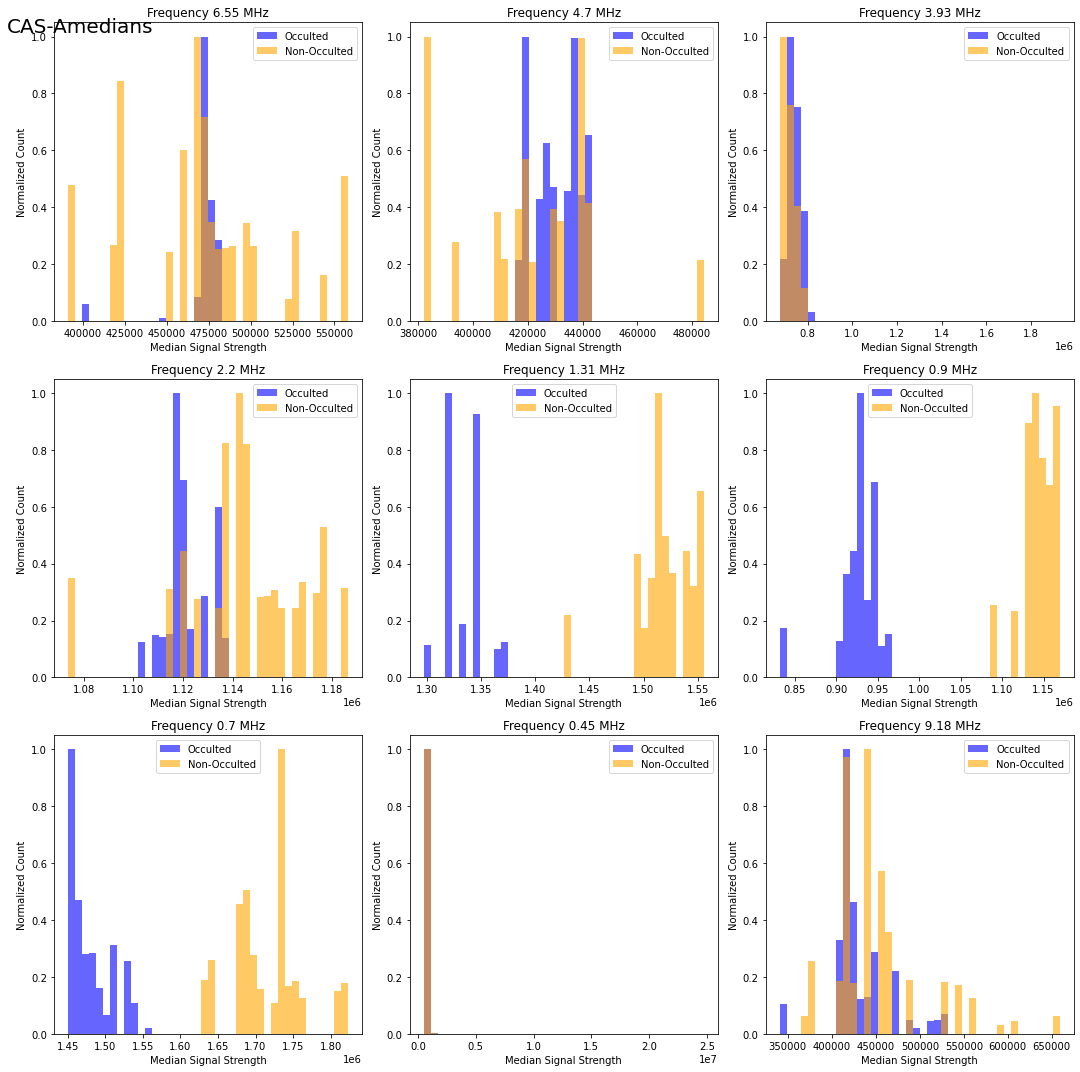

Saved histogram for CAS-Amedians as occultationResults\histograms\CAS-Amedians.pdf
Figure saved as occultationResults\histograms\Cygnus-Amedians.pdf


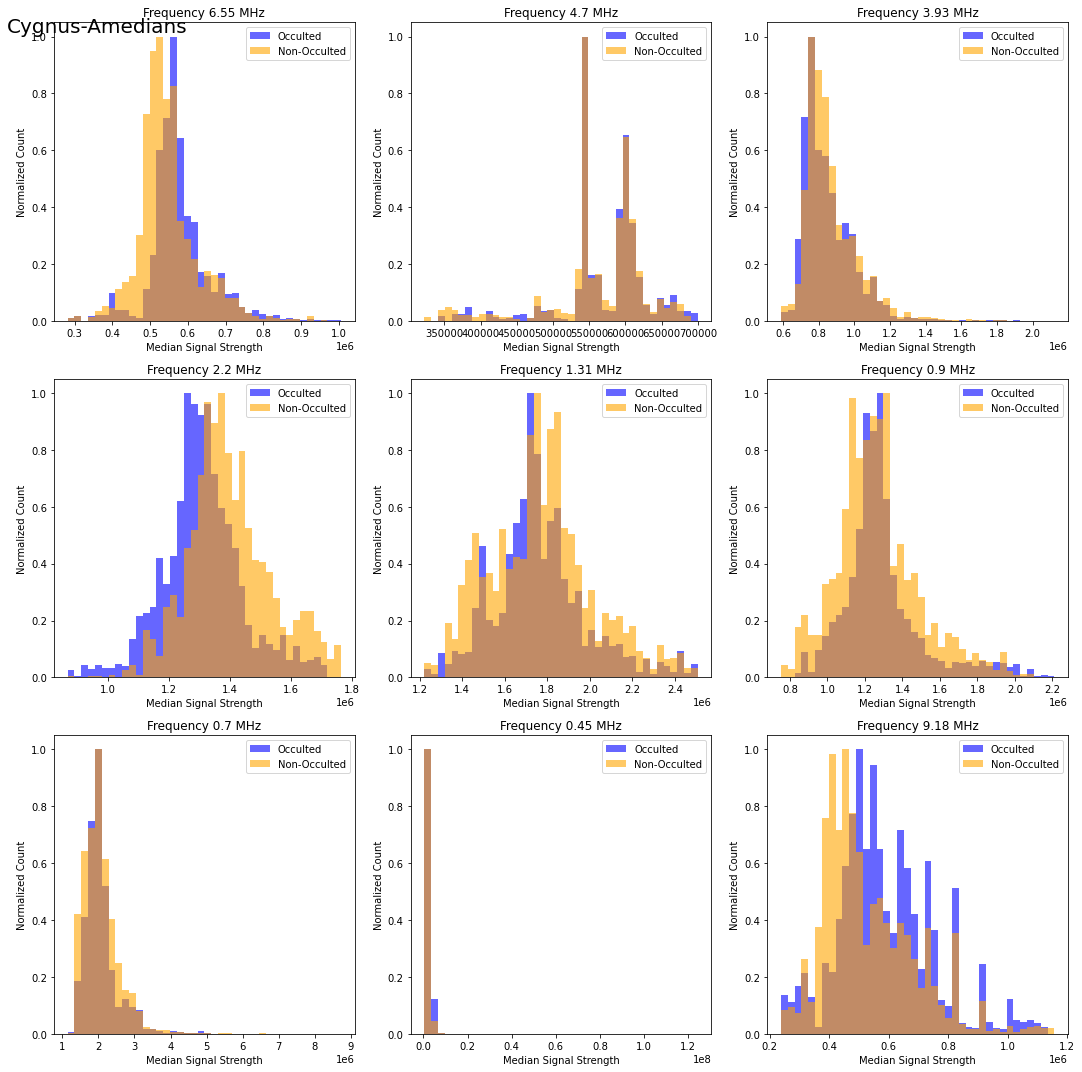

Saved histogram for Cygnus-Amedians as occultationResults\histograms\Cygnus-Amedians.pdf
Figure saved as occultationResults\histograms\Fornax-Amedians.pdf


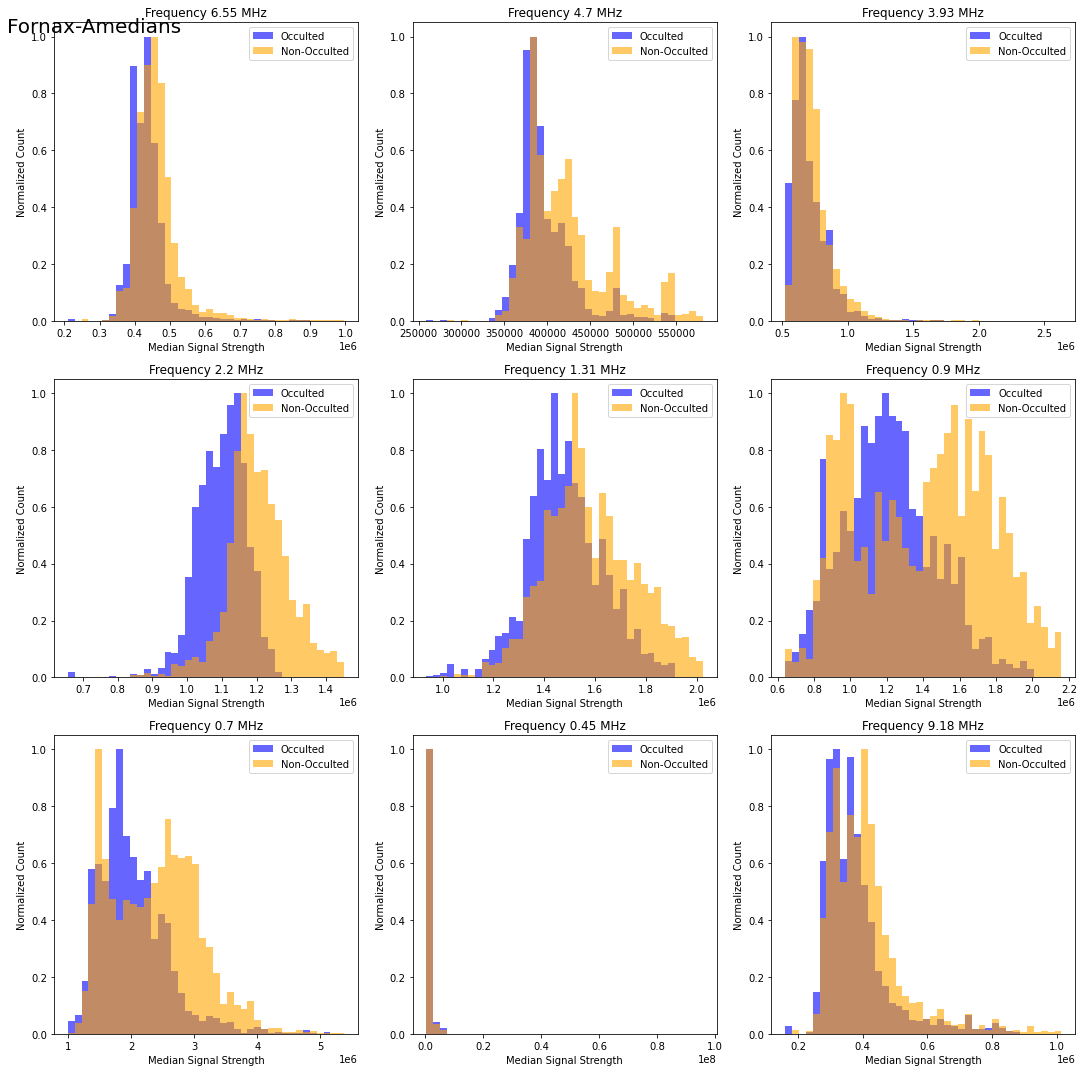

Saved histogram for Fornax-Amedians as occultationResults\histograms\Fornax-Amedians.pdf
Figure saved as occultationResults\histograms\Jupitermedians.pdf


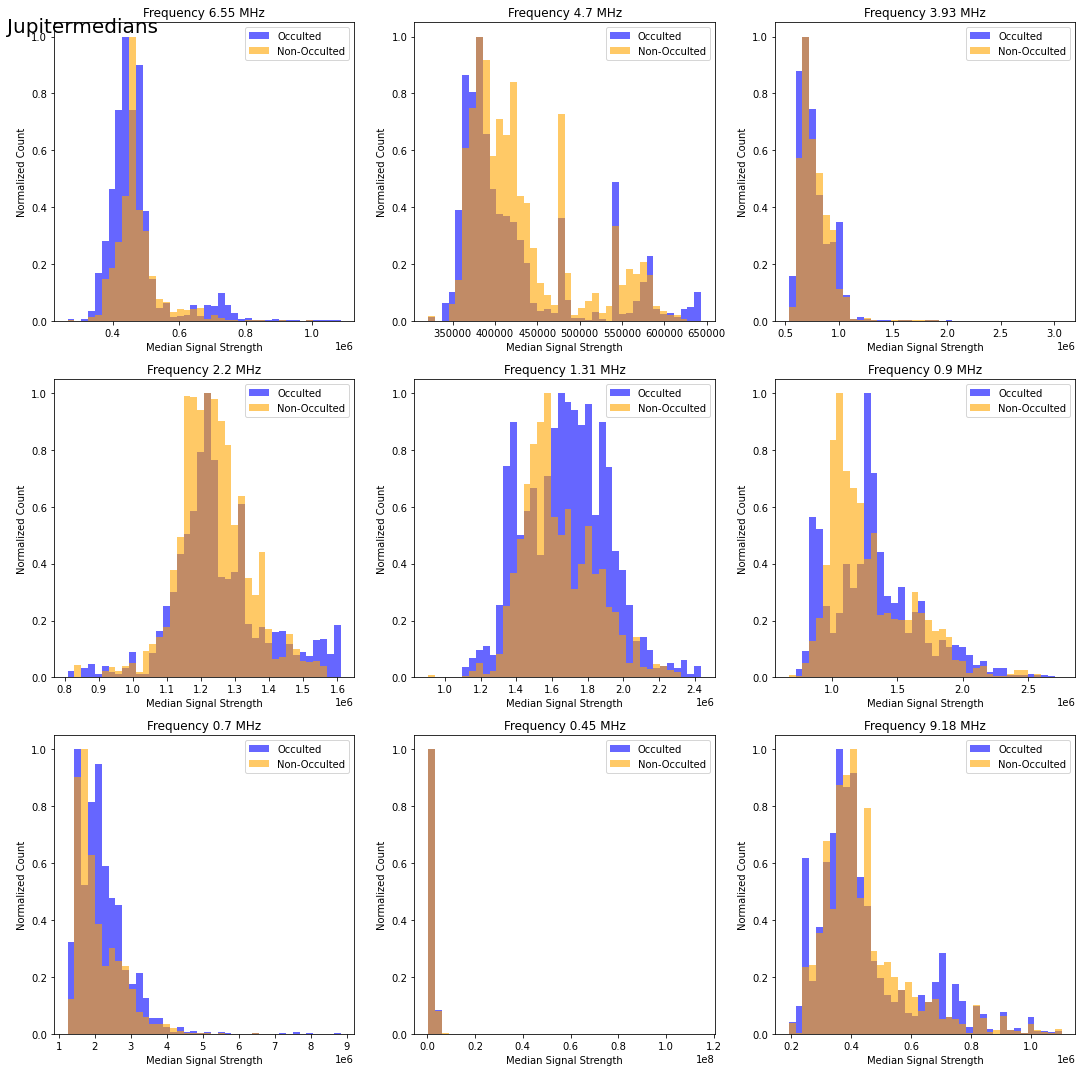

Saved histogram for Jupitermedians as occultationResults\histograms\Jupitermedians.pdf
Figure saved as occultationResults\histograms\Marsmedians.pdf


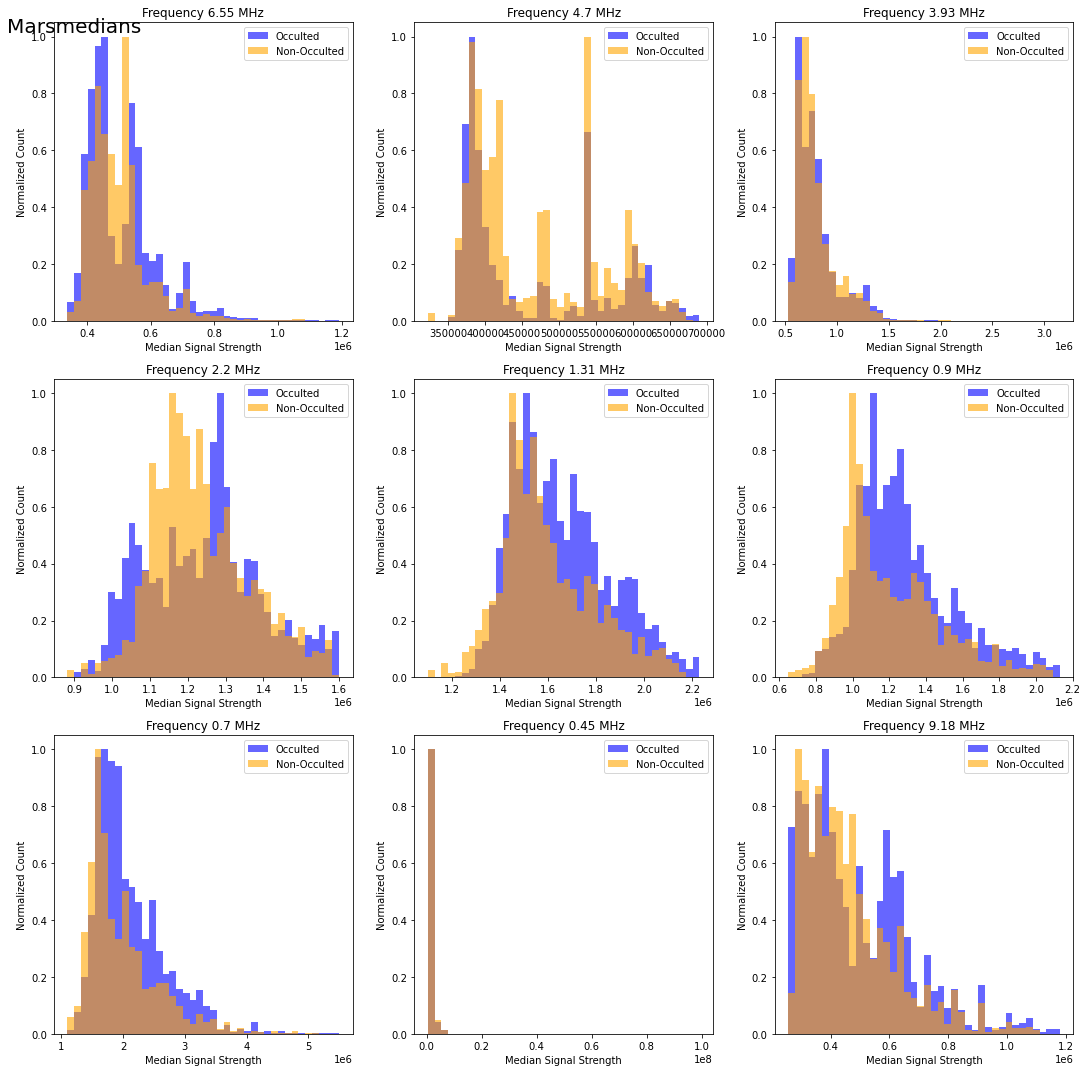

Saved histogram for Marsmedians as occultationResults\histograms\Marsmedians.pdf
Figure saved as occultationResults\histograms\Mercurymedians.pdf


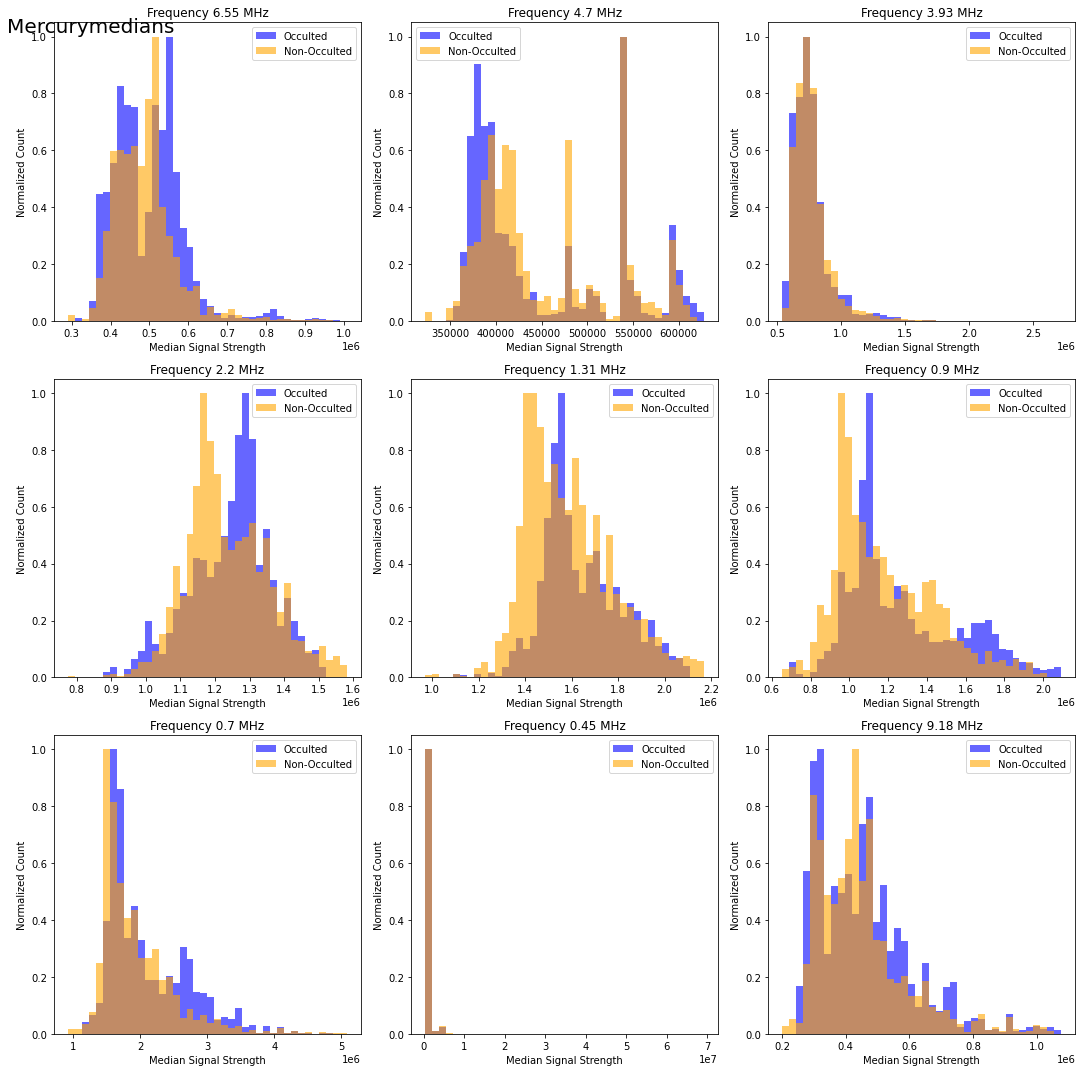

Saved histogram for Mercurymedians as occultationResults\histograms\Mercurymedians.pdf
Figure saved as occultationResults\histograms\Neptunemedians.pdf


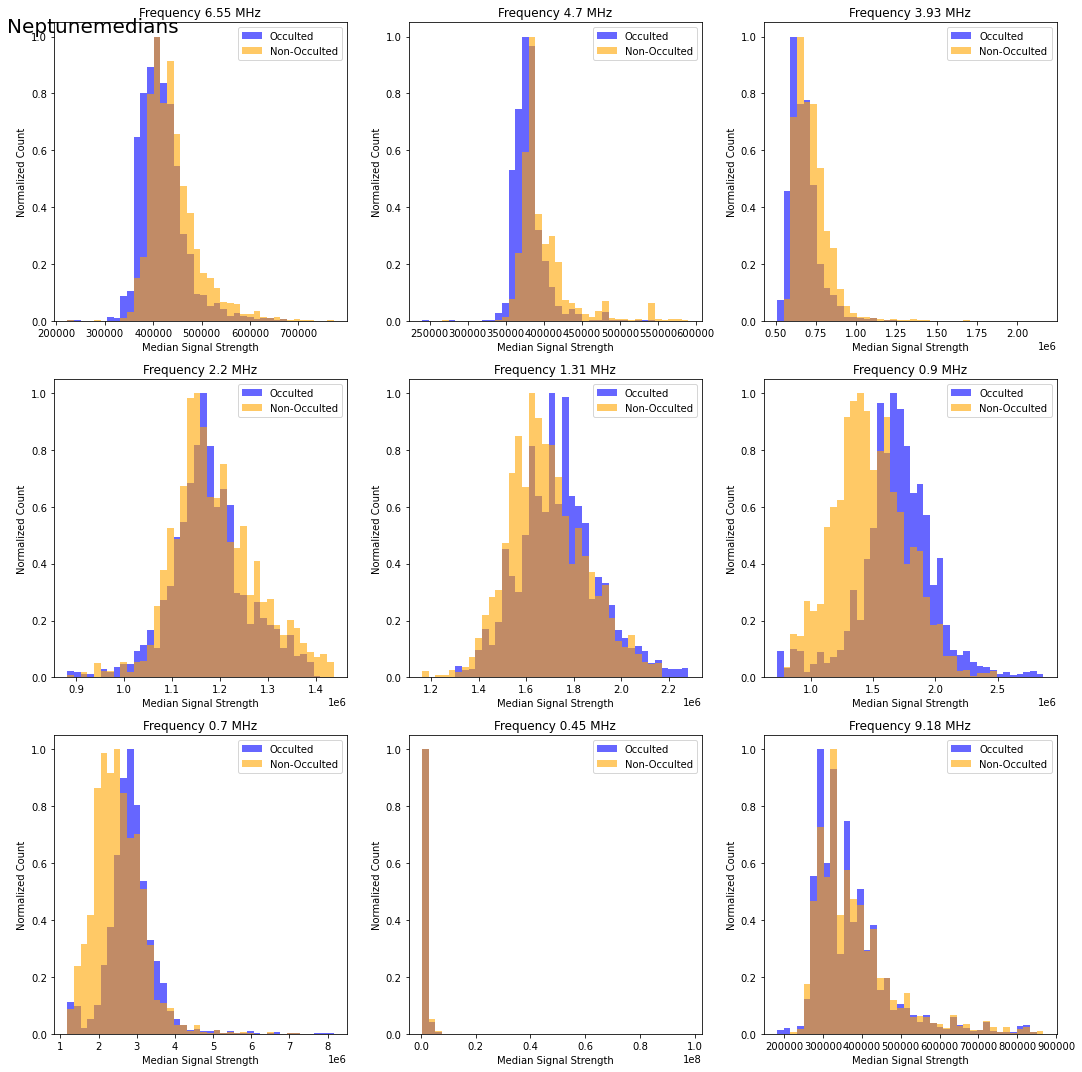

Saved histogram for Neptunemedians as occultationResults\histograms\Neptunemedians.pdf
Figure saved as occultationResults\histograms\Sag-Amedians.pdf


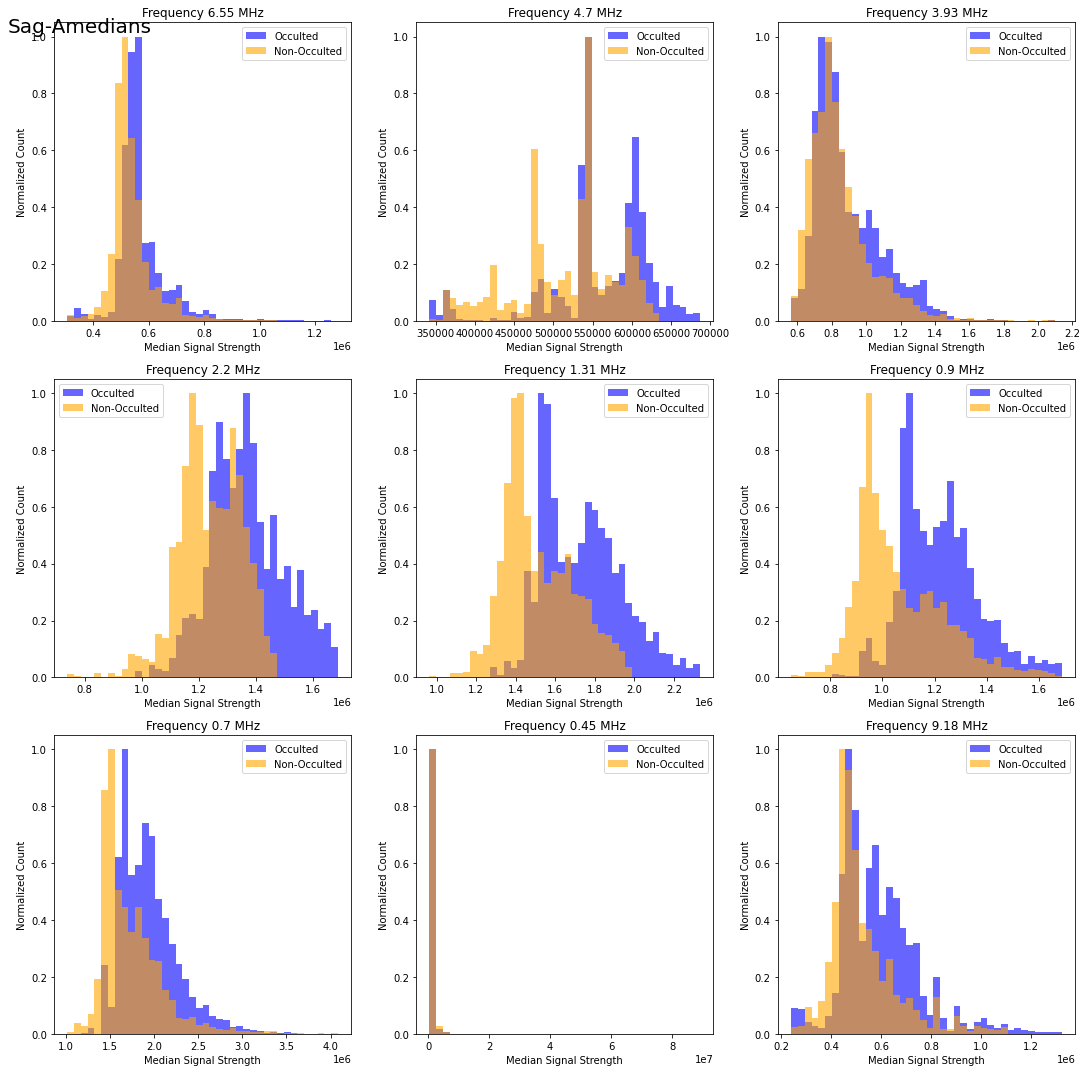

Saved histogram for Sag-Amedians as occultationResults\histograms\Sag-Amedians.pdf
Figure saved as occultationResults\histograms\Saturnmedians.pdf


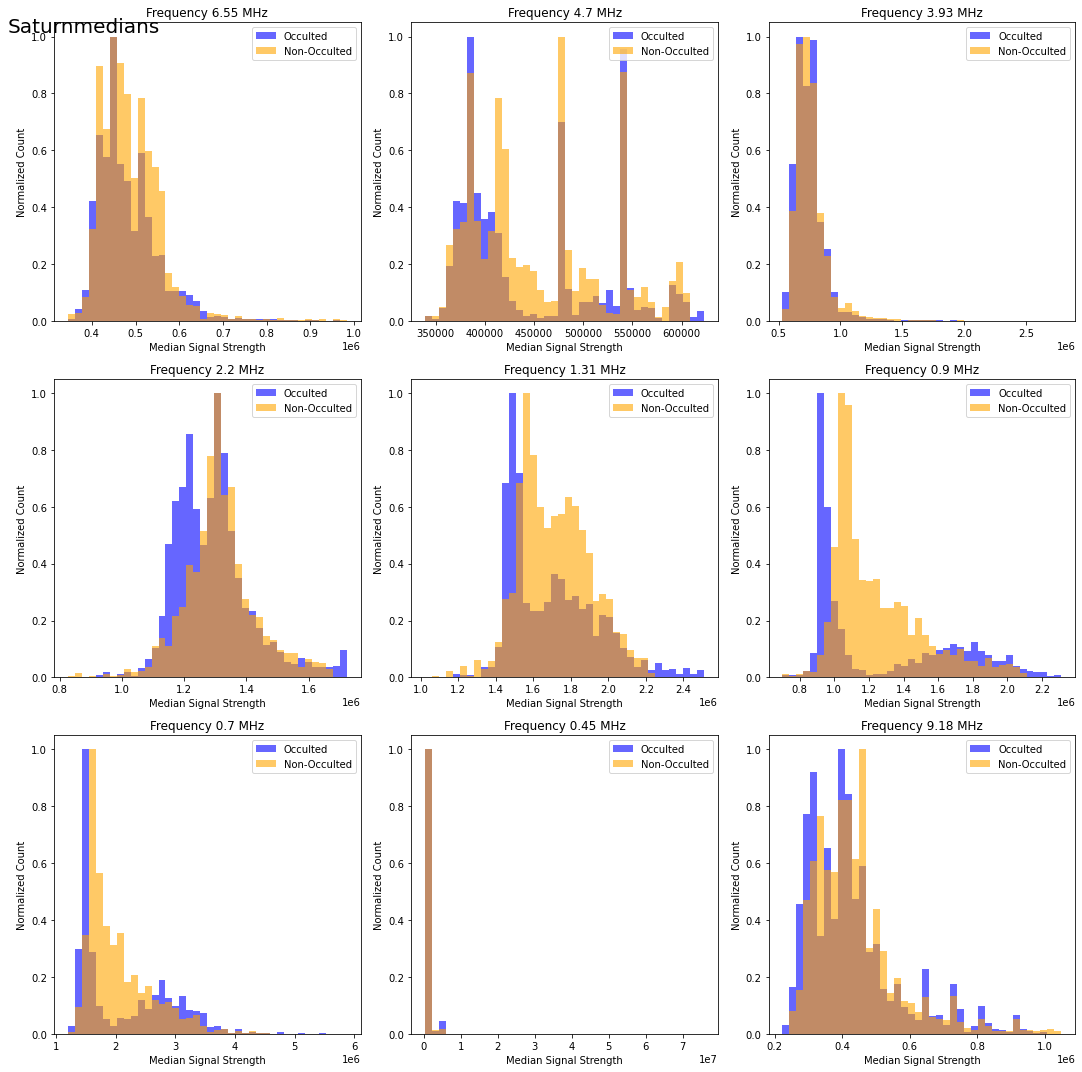

Saved histogram for Saturnmedians as occultationResults\histograms\Saturnmedians.pdf
Figure saved as occultationResults\histograms\Uranusmedians.pdf


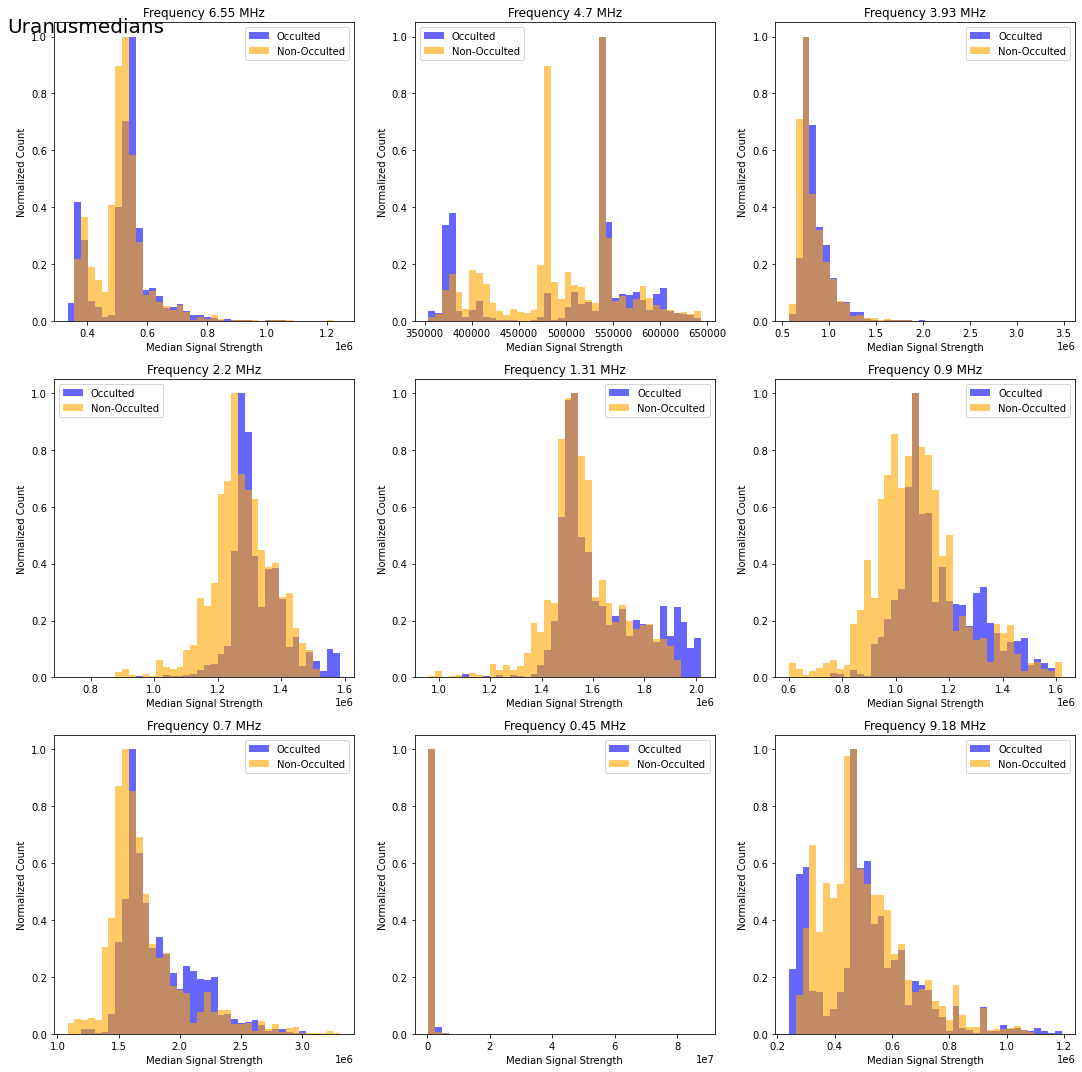

Saved histogram for Uranusmedians as occultationResults\histograms\Uranusmedians.pdf
Figure saved as occultationResults\histograms\Venusmedians.pdf


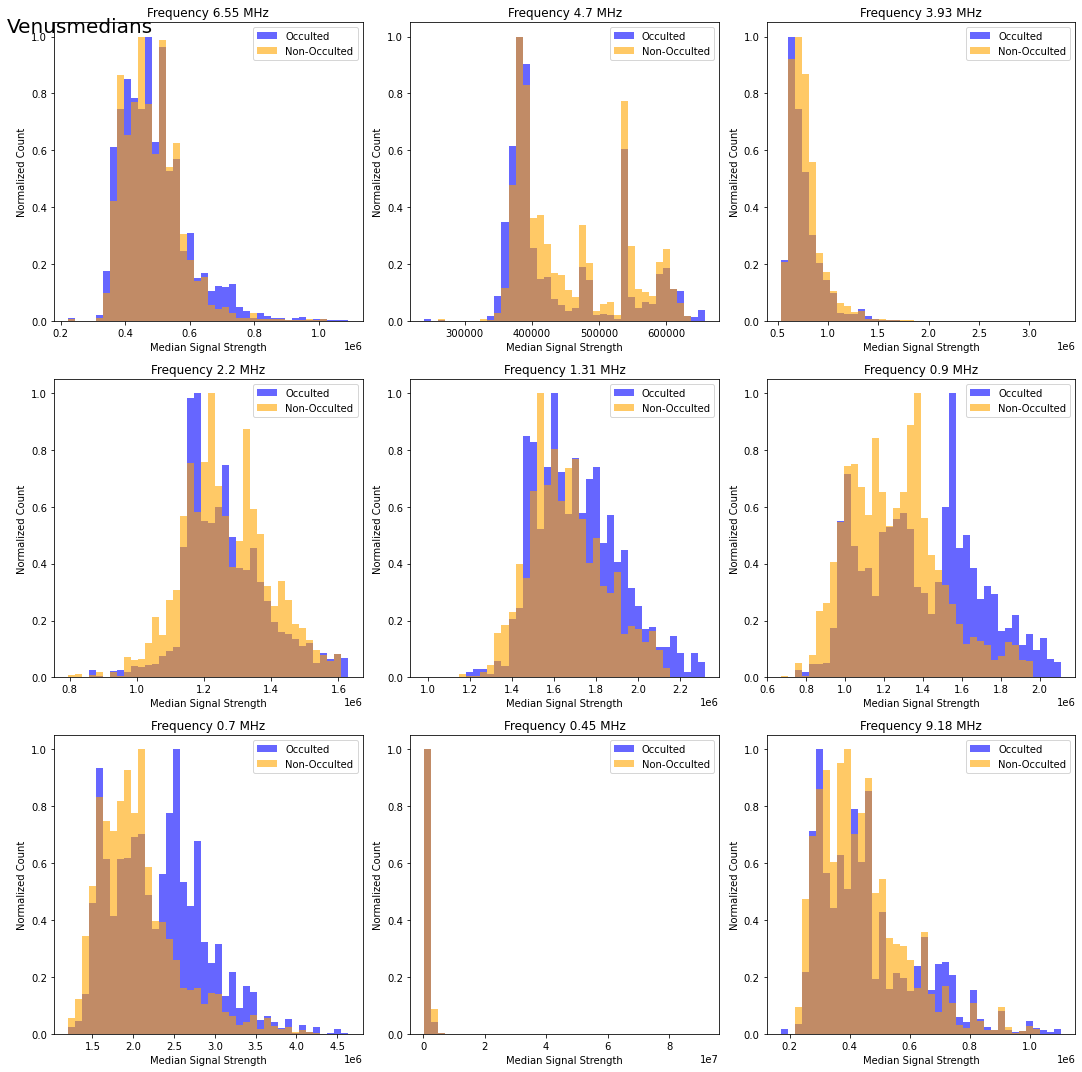

Saved histogram for Venusmedians as occultationResults\histograms\Venusmedians.pdf


In [24]:
for pickle_file in pickle_files:
    # Extract the source name from the filename (removing the directory and extension)
    source_name = os.path.splitext(os.path.basename(pickle_file))[0]

    # Load the stats dictionary
    with open(pickle_file, "rb") as f:
        stats = pickle.load(f)

    # Define the save path for the histogram
    save_path = os.path.join(output_dir, f"{source_name}.pdf")

    # Generate and save the histogram
    rae.plotNormalizedOccultationHistograms(stats,use_std_weights=True,apply_filter=True,min_bin_percentage=0.1, fig_label=source_name, save_path=save_path)

    print(f"Saved histogram for {source_name} as {save_path}")